In [1]:
import sys
import pathlib

In [31]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from tqdm.auto import tqdm

In [3]:
%load_ext autoreload
%autoreload 2

In [26]:
sys.path.append("..")
from src.preprocess import preprocess, discrete_timestep, transform_df_to_trajectory_gdf
from src.utils import WorldDefinition, assign_color, point_to_bbox
from src.visualize import visualize_objects, ObjectVisualization
from src.opendd import VEHICLE_CLASSES

In [50]:
FREQUENCY = 30
DURATION = 700

In [51]:
data_path = "../data/interim/rdb1.parquet"
df = pd.read_parquet(data_path)

In [52]:
df.head()

,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,MEASUREMENT
0,1,0.000000,1,619302.33,5809133.78,0.453485,4.74,0.1415,-0.1201,0.0747,Heavy Vehicle,2.7892,6.0217,rdb1_1
1,2,0.033367,1,619302.47,5809133.85,0.452985,4.75,0.1341,-0.1156,0.0679,Heavy Vehicle,2.7892,6.0217,rdb1_1
2,3,0.066733,1,619302.61,5809133.91,0.452485,4.75,0.1316,-0.1063,0.0776,Heavy Vehicle,2.7892,6.0217,rdb1_1
3,4,0.100100,1,619302.76,5809133.98,0.451985,4.75,0.1368,-0.0920,0.1013,Heavy Vehicle,2.7892,6.0217,rdb1_1
4,5,0.133467,1,619302.90,5809134.05,0.451485,4.76,0.1568,-0.0729,0.1388,Heavy Vehicle,2.7892,6.0217,rdb1_1


In [53]:
df = df[df["MEASUREMENT"] == "rdb1_1"]

In [54]:
df.loc[:, "k"] = discrete_timestep(df, FREQUENCY)

In [55]:
df = df[df["k"] < FREQUENCY*DURATION]

In [56]:
df = df.sort_values("k")

In [57]:
gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df["UTM_X"], df["UTM_Y"]), crs='EPSG:25832')

In [58]:
gdf["bbox"] = gdf.apply(lambda row:
                            point_to_bbox(row.geometry, row["WIDTH"],
                                          row["LENGTH"],
                                          row["UTM_ANGLE"],
                                          as_linestring=True), axis=1)

C:\Users\kopyt\anaconda3\envs\opendd-env\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [59]:
gdf = gdf.set_geometry("bbox")

In [60]:
gdf.head()

,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,MEASUREMENT,k,geometry,bbox
0,1,0.0,1,619302.33,5809133.78,0.453485,4.74,0.1415,-0.1201,0.0747,Heavy Vehicle,2.7892,6.0217,rdb1_1,0,POINT (619302.330 5809133.780),"LINEARRING (619304.426 5809136.353, 619305.648..."
897,898,0.0,3,619281.51,5809126.72,3.813485,1.32,0.0693,0.0130,0.0681,Car,1.8667,3.7854,rdb1_1,0,POINT (619281.510 5809126.720),"LINEARRING (619280.610 5809124.811, 619279.448..."
1138,1139,0.0,4,619288.84,5809134.99,4.276385,3.78,0.9199,0.3400,-0.8548,Car,1.7642,4.4819,rdb1_1,0,POINT (619288.840 5809134.990),"LINEARRING (619288.693 5809132.586, 619287.094..."
1424,1425,0.0,5,619316.99,5809146.38,1.354885,4.60,1.3951,-1.2106,0.6932,Medium Vehicle,2.1041,4.8186,rdb1_1,0,POINT (619316.990 5809146.380),"LINEARRING (619316.479 5809148.959, 619318.534..."
1640,1641,0.0,6,619352.15,5809156.25,0.374685,12.77,0.1075,0.1027,-0.0318,Car,2.2045,4.9059,rdb1_1,0,POINT (619352.150 5809156.250),"LINEARRING (619354.029 5809158.174, 619354.836..."


In [61]:
# get traffic lanes
trafficlanes_shapefile = pathlib.Path("../data/raw/rdb1/map_rdb1/shapefiles_trafficlanes")
trafficlanes = gpd.read_file(trafficlanes_shapefile)

In [62]:
gdf["color"] = assign_color(gdf["OBJID"])

In [63]:
gdf.head()

,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,MEASUREMENT,k,geometry,bbox,color
0,1,0.0,1,619302.33,5809133.78,0.453485,4.74,0.1415,-0.1201,0.0747,Heavy Vehicle,2.7892,6.0217,rdb1_1,0,POINT (619302.330 5809133.780),"LINEARRING (619304.426 5809136.353, 619305.648...",#308774
897,898,0.0,3,619281.51,5809126.72,3.813485,1.32,0.0693,0.0130,0.0681,Car,1.8667,3.7854,rdb1_1,0,POINT (619281.510 5809126.720),"LINEARRING (619280.610 5809124.811, 619279.448...",#32D102
1138,1139,0.0,4,619288.84,5809134.99,4.276385,3.78,0.9199,0.3400,-0.8548,Car,1.7642,4.4819,rdb1_1,0,POINT (619288.840 5809134.990),"LINEARRING (619288.693 5809132.586, 619287.094...",#6706D7
1424,1425,0.0,5,619316.99,5809146.38,1.354885,4.60,1.3951,-1.2106,0.6932,Medium Vehicle,2.1041,4.8186,rdb1_1,0,POINT (619316.990 5809146.380),"LINEARRING (619316.479 5809148.959, 619318.534...",#E805DA
1640,1641,0.0,6,619352.15,5809156.25,0.374685,12.77,0.1075,0.1027,-0.0318,Car,2.2045,4.9059,rdb1_1,0,POINT (619352.150 5809156.250),"LINEARRING (619354.029 5809158.174, 619354.836...",#846A32


In [104]:
t_move_off = 378.537167
obj_ids = [235, 239]

In [109]:
start_k = int((t_move_off - 2)* FREQUENCY) 
end_k = int((t_move_off + 4)* FREQUENCY)


In [110]:
gdf_animation = gdf[gdf["k"].between(start_k, end_k) & gdf["OBJID"].isin(obj_ids)]

In [111]:
gdf_animation.head()

,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,MEASUREMENT,k,geometry,bbox,color
143444,143445,376.542833,235,619296.03,5809130.37,0.726185,0.03,0.0968,-0.0169,0.0953,Car,2.0,4.6796,rdb1_1,11296,POINT (619296.030 5809130.370),"LINEARRING (619297.115 5809132.671, 619298.444...",#956AF6
146573,146574,376.542833,239,619287.99,5809123.33,0.651085,1.47,2.7125,-0.0853,-2.7112,Car,2.0,4.5180,rdb1_1,11296,POINT (619287.990 5809123.330),"LINEARRING (619289.181 5809125.494, 619290.393...",#55E1DB
146574,146575,376.576200,239,619288.02,5809123.36,0.651785,1.38,2.6044,-0.0826,-2.6031,Car,2.0,4.5180,rdb1_1,11297,POINT (619288.020 5809123.360),"LINEARRING (619289.209 5809125.525, 619290.423...",#55E1DB
143445,143446,376.576200,235,619296.03,5809130.37,0.726185,0.03,0.1017,-0.0194,0.0999,Car,2.0,4.6796,rdb1_1,11297,POINT (619296.030 5809130.370),"LINEARRING (619297.115 5809132.671, 619298.444...",#956AF6
143446,143447,376.609567,235,619296.03,5809130.37,0.726185,0.04,0.1054,-0.0214,0.1032,Car,2.0,4.6796,rdb1_1,11298,POINT (619296.030 5809130.370),"LINEARRING (619297.115 5809132.671, 619298.444...",#956AF6


  0%|          | 0/181 [00:00<?, ?it/s]

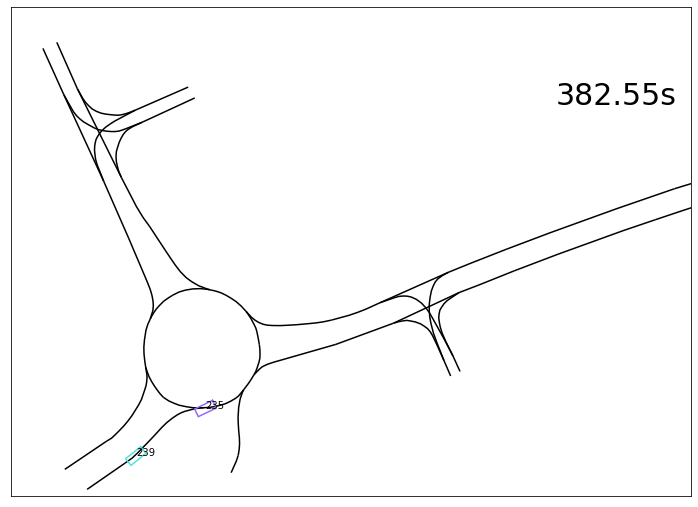

In [114]:
fig, ax = plt.subplots(figsize=(16, 9), facecolor="w")

moviewriter = FFMpegWriter(FREQUENCY)

with moviewriter.saving(fig, 'test.gif', dpi=100):
    
    for k, timestep_data in tqdm(gdf_animation.groupby("k"), total=gdf_animation["k"].nunique()):
        ax.clear()
        
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        objects = [ObjectVisualization(row["OBJID"], row["bbox"], color=row["color"]) for i, row in timestep_data.iterrows()]

        visualize_objects(ax, objects, trafficlanes)

        ax.set_xlim(619260, 619420)
        ax.set_ylim(5809115, 5809230)
        
        t = timestep_data.iloc[0]["TIMESTAMP"]
        
        ax.text(0.8, 0.8, f"{t:.2f}s", transform=ax.transAxes, fontsize=30)

        moviewriter.grab_frame()
        